# Going beyond galaxies as tracers with `halomod`

`halomod` is written in a way that is most native to applications of halo models of galaxies. Therefore, modifications and extensions in the context of galaxy clustering (as well as HI assuming HI is trivially related to galaxies) are very straightforward. However, it may not be as straightforward when dealing with other tracers. In this tutorial, we use the flux density power spectrum of [arxiv:0906.3020](https://arxiv.org/abs/0906.3020) to demonstrate how to fully utilise the flexibility of `halomod`.

The flux density power spectrum can modelled as (see Sec 2.3 of [arxiv:0906.3020](https://arxiv.org/abs/0906.3020)):
$$
P_{1h}(k) = |u_J(k)|^2 \int_{M_{\rm min}}^{\infty} {\rm d}m\, n(m) \bigg(\frac{m}{\bar{\rho}_{\rm gal}}\bigg)^2
$$

$$
P_{2h}(k)=|u_J(k)|^2\bigg[\int_{M_{\rm min}}^{\infty}{\rm d}m\,n(m)b(m)\Big(\frac{m}{\bar{\rho}_{\rm gal}}\Big)\bigg]^2 P_{\rm lin}(k)
$$

where $u_J(k)={\rm arctan}(k\lambda_{\rm mfp})/(k\lambda_{\rm mfp})$

## HOD
Once we have the expression of the power spectrum we want, we should try to identify the halo model components. Comparing it to the standard halo model formalism, it's easy to see that it effectively means:
$$
\langle M_{\rm cen}\rangle \equiv 0
$$

$$
\langle M_{\rm sat}\rangle \equiv A_{\rm sat}
$$

where $A_{\rm sat}$ is a constant so that the total satellite occupation is equal to the mean mass density of galaxies:

$$
\int_{M_{\rm min}} {\rm d}m\, n(m)A = \bar{\rho}_{\rm gal}
$$

This HOD has already been defined within `halomod` by the `Constant` HOD class:

In [21]:
import hmf
import numpy as np
from matplotlib import pyplot as plt

import halomod
from halomod import TracerHaloModel

In [23]:
print(f"Using halomod v{halomod.__version__} and hmf v{hmf.__version__}")

Using halomod v2.0.2.dev51+geee0902 and hmf v3.5.0


In [3]:
hm = TracerHaloModel(hod_model="Constant", transfer_model="EH")

In [4]:
hm.central_occupation

0

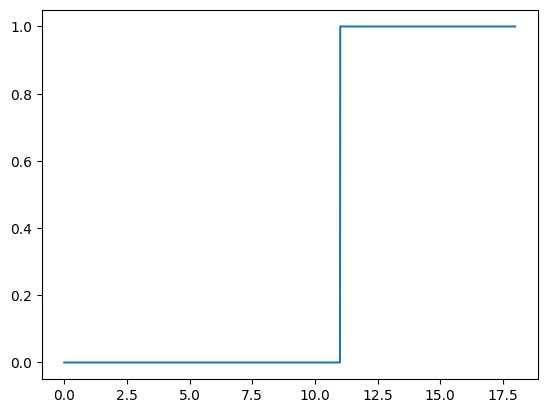

In [6]:
plt.plot(np.log10(hm.m), hm.satellite_occupation);

## Density Profile

The density profile from [arxiv:0906.3020](https://arxiv.org/abs/0906.3020) is already included as `PowerLawWithExpCut`:

$$
\rho(r) = \rho_s \big(r/r_s \big)^{-b}{\rm exp}\big[-a r/r_s\big]
$$

and in this specific case we have $b=2$.

However, the native way of defining density profile in `halomod` is to relate it to the characteristic scale $r_s$, which is related to the concentration parameter. Therefore, for each halo of different mass the shape of the density profile is different. But in this case we want to keep the shape of the profile the same for all halos. Although `halomod` does not provide a readily available solution, note:

$$
m \sim r_s^3c^3(m,z)
$$

$$
r_s \sim m^{1/3}c^{-1}(m,z)
$$

Therefore, we only need to define a special concentration-mass relation to keep $r_s$ constant. Suppose we construct a C-M relation:

In [7]:
from hmf.halos.mass_definitions import SOMean

from halomod.concentration import CMRelation

In [8]:
class CMFlux(CMRelation):
    _defaults = {"c_0": 4}
    native_mdefs = (SOMean(),)

    def cm(self, m, z):
        return self.params["c_0"] * (m * 10 ** (-11)) ** (1 / 3)

In [9]:
hm = TracerHaloModel(
    halo_concentration_model=CMFlux,
    halo_profile_model="PowerLawWithExpCut",
    halo_profile_params={"b": 2.0, "a": 1.0},
    hod_model="Constant",
    transfer_model="EH",
)

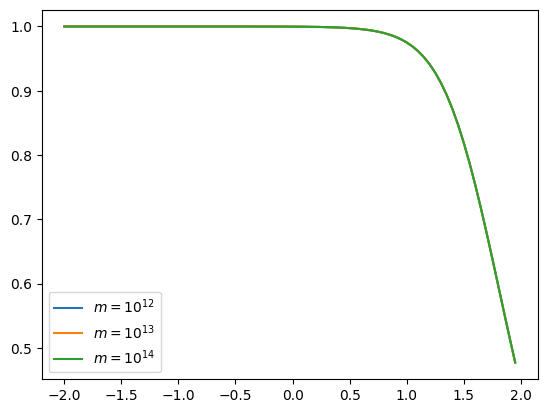

In [10]:
plt.plot(np.log10(hm.k_hm), hm.tracer_profile.u(hm.k_hm, m=1e12), label="$m = 10^{12}$")
plt.plot(np.log10(hm.k_hm), hm.tracer_profile.u(hm.k_hm, m=1e13), label="$m = 10^{13}$")
plt.plot(np.log10(hm.k_hm), hm.tracer_profile.u(hm.k_hm, m=1e14), label="$m = 10^{14}$")
plt.legend();

One can see that indeed the density profile is now independant of halo mass

## Tuning parameters

So far the parameters are randomly set without clear physical meanings. We can easily tune these parameters to desired physical values.

Suppose we want the mass density of galaxies to be $10^{-2}$ of the total critical density:

In [11]:
rhoc = hm.cosmo.critical_density0.to("Msun/Mpc^3").value * hm.cosmo.h**2

In [12]:
hm.mean_tracer_den / rhoc

np.float64(6.046025739923064e-13)

That means the parameter `logA` for the HOD should be changed to:

In [13]:
-np.log10(hm.mean_tracer_den / rhoc)

np.float64(12.218530008219606)

We can simply set this on the existing model (everything that's dependent on it will be auto-updated):

In [14]:
hm.hod_params = {"logA": -np.log10(hm.mean_tracer_den / rhoc)}

In [15]:
hm.mean_tracer_den / rhoc

np.float64(1.000000000000003)

The density profile should satisfy $r_s/a = \lambda_{\rm mfp}$. $r_s$ can be obtained as:

In [16]:
rs = hm.halo_profile.scale_radius(1e11)

Just to make sure, we calculate $r_s$ for a different halo mass:

In [17]:
hm.halo_profile.scale_radius(1e12)

np.float64(0.027958379670006795)

in the units of Mpc/h. Assume we want $\lambda_{\rm mfp} = 10$ Mpc/h:

In [18]:
hm.halo_profile_params = {"a": rs / 10}

Check the density profile to see the cut-off:

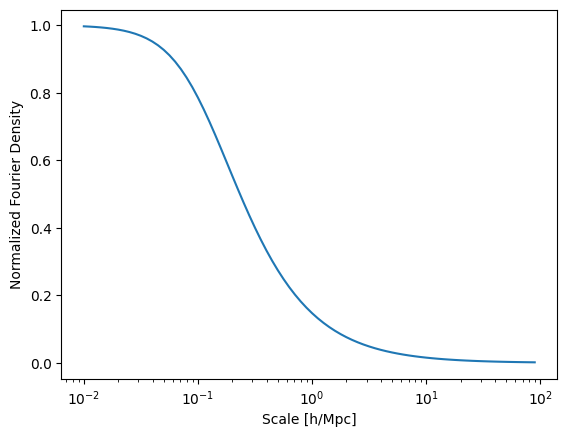

In [19]:
plt.plot(hm.k_hm, hm.tracer_profile.u(hm.k_hm, m=1e12))
plt.xlabel("Scale [h/Mpc]")
plt.ylabel("Normalized Fourier Density")
plt.xscale("log")

You can see it's indeed around 0.1 Mpc$^{-1}$h

Finally we can see the power spectrum:

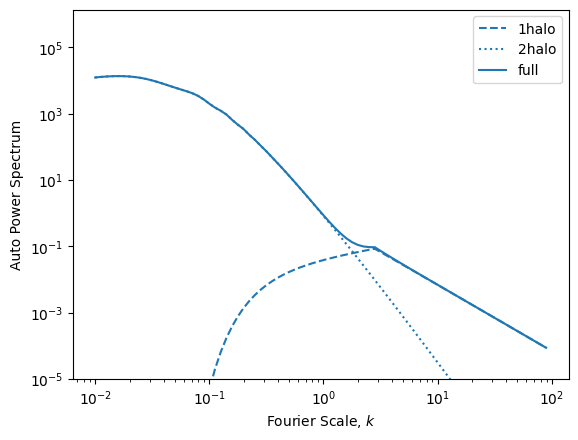

In [20]:
plt.plot(hm.k_hm, hm.power_1h_auto_tracer, ls="--", color="C0", label="1halo")
plt.plot(hm.k_hm, hm.power_2h_auto_tracer, ls=":", color="C0", label="2halo")
plt.plot(hm.k_hm, hm.power_auto_tracer, color="C0", label="full")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim(
    1e-5,
)
plt.xlabel("Fourier Scale, $k$")
plt.ylabel("Auto Power Spectrum");